# Insurance Data Analysis

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn.cross_validation as cv
from sklearn import preprocessing, metrics 

from sklearn.ensemble import  ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

import seaborn as sns
from sklearn.grid_search import GridSearchCV 


In [3]:
%matplotlib inline

## The Setup...

Here we will look at a Data Science challenge within the Insurance space.
Of all the industries rife with vast amounts of data, the Insurance market surely has to be one of the 
greatest treasure troves for both data scientist and insurers alike.

However, despite this bounty, much of the Insurance industry is still built around 17th century 'Actuarial' math, meaning the data trove is either under utilised or not used at all.

Even with the integration of more modern financial economics into the insurance process, much of it relies on 'assumption based' approaches - such as determining the Discount Rate to be used - this is where Machine Learning comes in.


## The Challenge...

Using a data set provided by Prudential Insurance as part of their recent Kaggle Challenge https://www.kaggle.com/c/prudential-life-insurance-assessment/download/train.csv.zip), we will apply a number data science techniques to visualise, better understand, statistically analyse and prepare the data for prediction.
The focus of this script will not be on outright 'predictive performance', but rather we will take a more 'data science'/ research oriented approach, focusing on model robustness and data understanding.

## The Data...

Our training set has 127 features and a response with 8 classes (this is an ordinal measure of risk, 1-8). We have around 60,000 insurance applications to work with.

Variable|                           Description
-|-|-|-
__Id__|                                 A unique identifier associated with an application.
__Product_Info_1-7__| 	                A set of normalized variables relating to the product applied for.
__Ins_Age__| 	                        Normalized age of applicant.
__Ht __	    |                            Normalized height of applicant.
__Wt__| 	                                Normalized weight of applicant.
__BMI__ |	                            Normalized BMI of applicant.
__Employment_Info_1-6 __	 |           Normalized variables relating to the employment history of the applicant.
__InsuredInfo_1-6 __	     |           Normalized variables providing information about the applicant.
__Insurance_History_1-9 __	   |         Normalized variables relating to the insurance history of the applicant.
__Family_Hist_1-5 	    __    |        Normalized variables relating to the family history of the applicant.
__Medical_History_1-41 	 __  |         Normalized variables relating to the medical history of the applicant.
__Medical_Keyword_1-48 	 __  |         Dummy variables relating to the presence of/absence of a medical keyword.
__Response 	           __   |          Target variable relating to the final application decision.

Read in the Data

In [4]:
df = pd.read_csv('train.csv', sep =',')
df.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


Visualize the Class counts using Seaborn countplot

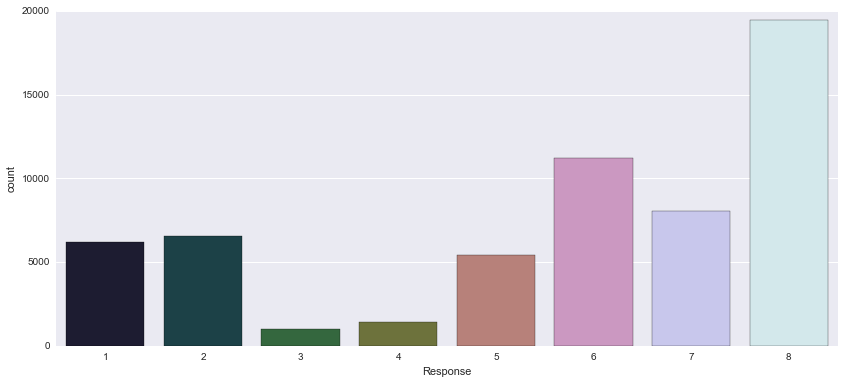

In [5]:
plt.rcParams['figure.figsize'] = (14.0,6.0)
sns.countplot(x='Response',data=df,palette="cubehelix", order = range(1,9))
#this shows an imbalance in our classes, suggesting we will need
#to be carefull when performing CV (Stratified).

Count the number of missing values in each of the Features

In [6]:
print("Feature  \t\t Nan Count   \t Pct")
for i,c in df.T.iterrows():
        
    count = sum(c.isnull())
    count = count.astype(float)

    if count >0:
                           
        print("%s   \t%5d   \t%.2f%%"  %(i, count, (count/59381)*100))

Feature  		 Nan Count   	 Pct
Employment_Info_1   	   19   	0.03%
Employment_Info_4   	 6779   	11.42%
Employment_Info_6   	10854   	18.28%
Insurance_History_5   	25396   	42.77%
Family_Hist_2   	28656   	48.26%
Family_Hist_3   	34241   	57.66%
Family_Hist_4   	19184   	32.31%
Family_Hist_5   	41811   	70.41%
Medical_History_1   	 8889   	14.97%
Medical_History_10   	58824   	99.06%
Medical_History_15   	44596   	75.10%
Medical_History_24   	55580   	93.60%
Medical_History_32   	58274   	98.14%


Before we can deal with these NaNs, we need to consider the statistical distributions of the various features.

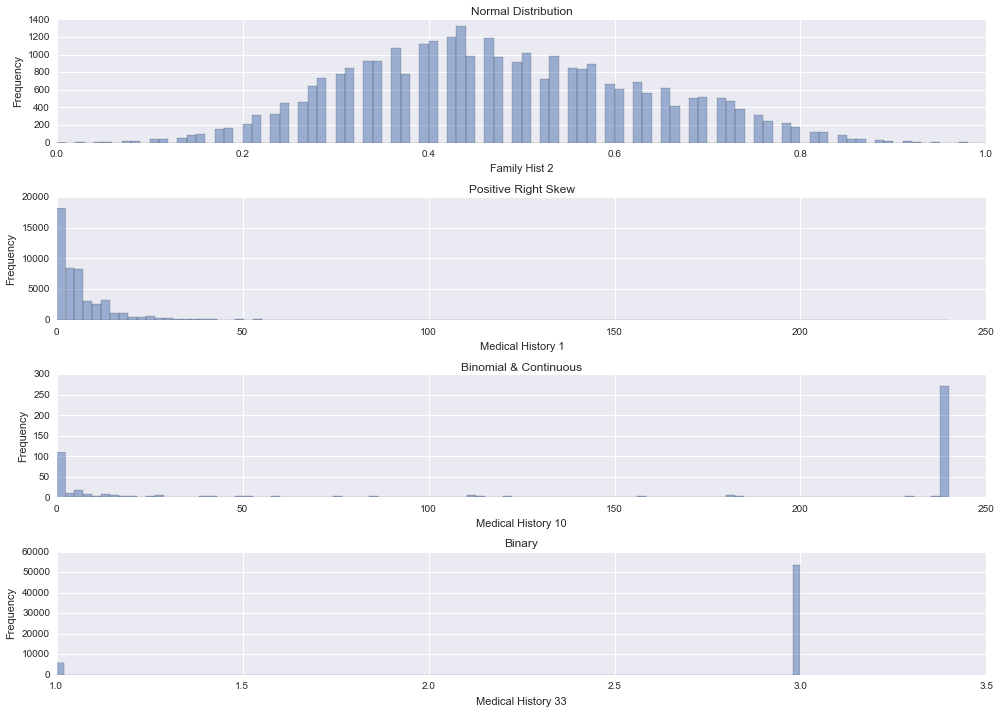

In [7]:
"""Here we can see that amongst our Features, we have a number of different
distributions.
This is to be expected amongst  Insurance data due to the breadth of
different metrics we have gathered
 """        
plt.rcParams['figure.figsize'] = (14.0, 10.0)

plt.subplot(4,1,1)    
df['Family_Hist_2'].plot(kind = 'hist',bins= 100, alpha = 0.5)
plt.title('Normal Distribution')
plt.xlabel('Family Hist 2')

plt.subplot(4,1,2)
df['Medical_History_1'].plot(kind = 'hist',bins = 100, alpha = 0.5)
plt.title('Positive Right Skew')
plt.xlabel('Medical History 1')

plt.subplot(4,1,3)
df['Medical_History_10'].plot(kind = 'hist', bins =100, alpha = 0.5)
plt.title('Binomial & Continuous')
plt.xlabel('Medical History 10')

plt.subplot(4,1,4)
df['Medical_History_33'].plot(kind = 'hist', bins =100, alpha = 0.5)
plt.title('Binary')
plt.xlabel('Medical History 33')

plt.tight_layout()

By looking at the dtypes of the features we can see 
all are numerical apart from 'Product Info 2' which is an alpha numeric
'object'.

In [8]:
df.dtypes.value_counts()


int64      109
float64     18
object       1
dtype: int64

As we want numerical data to work with we need to convert this feature.
There are a number of way of doing this but 'factorize' is an efficient method.

In [11]:
x = pd.factorize(df.ix[:,2])
x = x[0]
df['Product_Info_2'] = x


With over 100 features, it would be wise to assess the contribution each feature towards the response variable.
As we have lots of nan values we will drop those with over 50% missing values (which is 6 features) and fill the remaining
nans with median values (or 'pad' where necessary).

In [12]:
df.drop(['Medical_History_32','Medical_History_24','Medical_History_10',
         'Medical_History_15','Family_Hist_5','Family_Hist_3'],axis =1, inplace = True)

df.fillna(df.median(axis= 1),inplace = True)
df.fillna(method = 'pad',inplace = True)
df.fillna(method = 'bfill',inplace = True)

df.isnull().sum().sum()

0L

Now we seperate out or Features 'X' from our reponse 'y' which is in the last column of the Dataframe.

In [13]:
Xpd = df.ix[:,1:-1]
y = df.ix[:,-1:]


Pre-processing out data by scaling is neccessary for various Machine Learning classifiers to work.

In [14]:
X = preprocessing.scale(Xpd)
y = np.asarray(y).flatten().astype(float)


Here we use TrainTestSplit from Sckit-Learn to create our training and validation sets.

In [16]:
Xtrain, Xtest, Ytrain, Ytest = cv.train_test_split(X,y,test_size = 0.3,
                                                   random_state = 1)

## Important Features...

Our choice of classifier will be Extremely Randomized Trees - 'ExtraTreesClassifier' - from scikit learn.
The reasons for this choice include: its robustness to overfitting; it provides an average across a number of randomly sampled features from our feature set; unlike 'Random Forrests' from which it is loosely based, ExtraTrees chooses features randomly rather than the most discriminative threshold, this helps to reduce variance (albeit at the expense of bias); as we are using a (relatively) small data set of n=60000, we can afford the computational expense of fitting 100 trees.

In [19]:
clf = ExtraTreesClassifier(n_estimators = 100, random_state =0)

clf.fit(Xtrain,Ytrain)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

With our fitted classifier we can show the most important features.

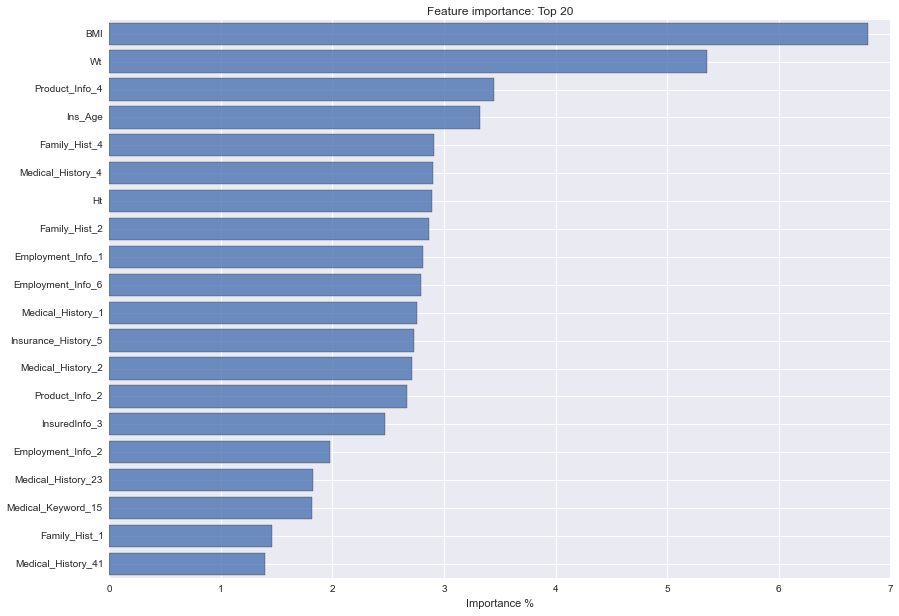

In [21]:
imp = pd.DataFrame({'features':Xpd.columns,'importance':clf.feature_importances_})

imp_head = imp.sort_values(by = 'importance', ascending =False)[:20]
imp_head = imp_head.sort_values(by = 'importance', ascending = True)

plt.rcParams['figure.figsize'] = (14.0,10.0)
plt.barh(np.arange(len(imp_head))+.5,imp_head.importance*100,
         align = 'center', alpha = 0.8)
plt.yticks(np.arange(len(imp_head))+.5, imp_head.features.values)         
plt.title('Feature importance: Top 20')
plt.xlabel('Importance %')


We can see the top 20 Features account for over 50% of the importance in our model.
Lets plot the pairwise plots among our features to visualise any relationships.
As we might expect, there is a strong positive relationship between BMI and Weight.

C:\Users\P\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


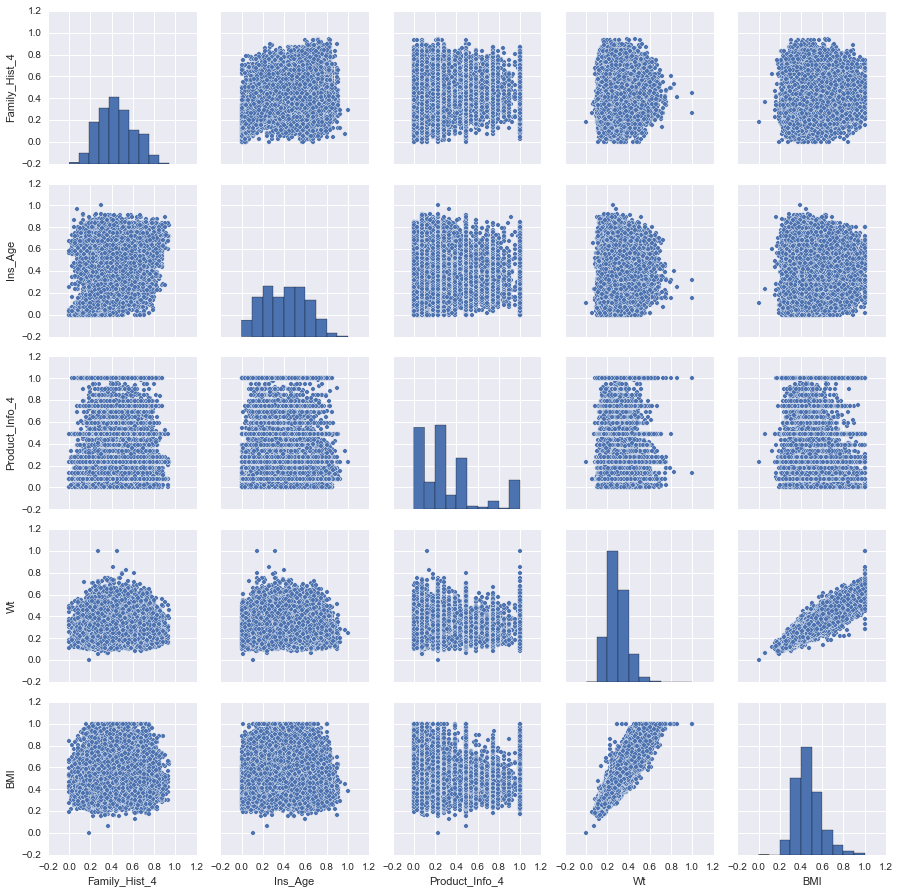

In [22]:
sns.pairplot(df[imp_head.features[-5:]])

By way of a comparison to our Extra Trees model above, we can run a Principal Components Analysis on the same Feature set
(unlabeled of course as its an Unsupervised method) and we see that where Extra Trees showed the 1st 20 Features accounted for around 50% of the variance in the data, PCA returns 38%.

Variance explained by first 20 components): 37.46%


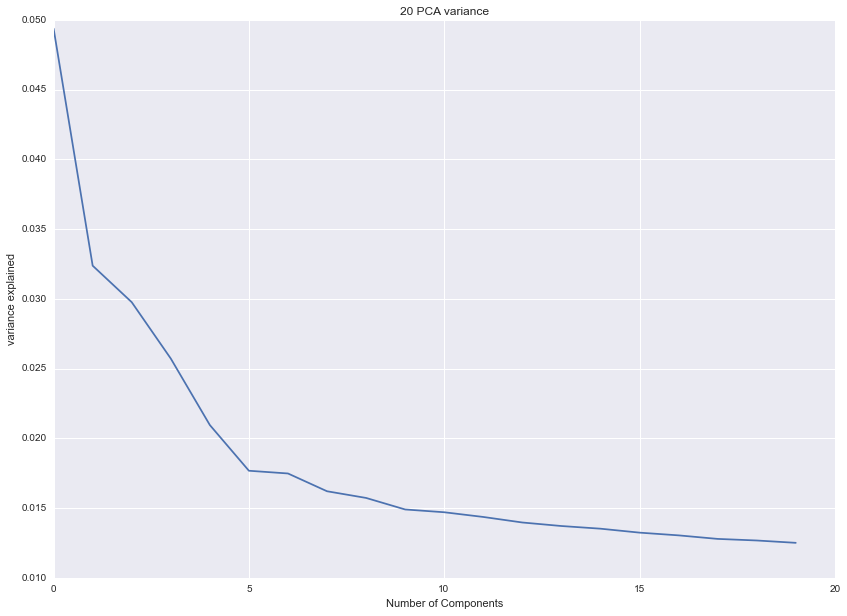

In [25]:
pca = PCA(n_components = 20)

pca.fit(Xtrain).transform(Xtrain)


s = pca.explained_variance_ratio_


plt.plot(s)
plt.xlabel('Number of Components')
plt.ylabel('variance explained')
plt.title('20 PCA variance')


print ('Variance explained by first %d components): %.2f%%'%(20, sum(pca.explained_variance_ratio_)*100))


We can delve deeper into the Features that we now know to be most significant and apply greater statistical scrutiny.

Take a look at the relative distributions of 'BMI' for each of the responses:
Most distributions have a skew and fat right tails but most noticeable is the difference in distributions amongst the responses (this is in part due to the difference in sample size for each of the 1-8 response variables - see 1st chart).

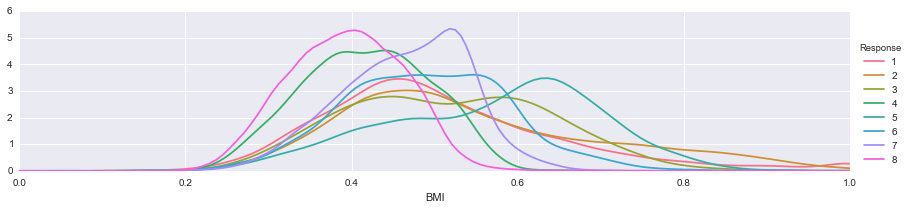

In [26]:
dist_plot = sns.FacetGrid(df, hue="Response",aspect=4, hue_order=[1,2,3,4,5,6,7,8])
dist_plot.map(sns.kdeplot,'BMI')

dist_plot.add_legend()
dist_plot.set(xlim=(0, 1.0))


## Prediction...

An easy mistake to make when viewing this data challenge would be to view it as a 'Multi-Class' Classification problem (with 8 target responses 1-8) for our risk ratings.

What we actually have, is part way between a Regression and a Classification task: an 'Ordinal Regression' task.
The 'ordinal' nature of the response variable (a risk rating) means we will have to use a few tools from our Data Scientist toolkit to make the model fit for purpose.


We will use Gradient Boosting Regressor for its performance and Grid Search CV to perform Cross Validation and select our Hyperparameters.

In [34]:
pg= {'loss':['ls','huber','quantile'],
           'learning_rate':[0.01,0.2,0.5],
'max_depth':[1,3,5]}

grid = GridSearchCV(GradientBoostingRegressor(),param_grid =pg, cv =5)


grid.fit(Xtrain,Ytrain)

bestloss = grid.best_params_['loss']
bestlr = grid.best_params_['learning_rate']
bestm = grid.best_params_['max_depth']

print bestloss
print bestlr
print bestm


huber
0.2
1


We will then use these values to train our  optimized classifier.

In [35]:
a1 = GradientBoostingRegressor(loss = 'huber', learning_rate = 0.2,
                               max_depth = 1)    
a1fit = a1.fit(Xtrain,Ytrain)    


a1pred= a1fit.predict(Xtest)

"""continuous"""
a1pred[:5]

array([ 2.7243947 ,  7.14760248,  6.40172686,  7.08352828,  4.831419  ])

At this point we need to do some trickery to create our 'cut off points' for our ordinal regression.
That is, we will take our regression preditions (continuous) and 'bin' them into our (ordinal) response classes.
We do this using the 'Digitize' function in Numpy.

In [36]:
preds  =a1pred
splits = [1,2,3,4,5,6,7,8]
resp = np.digitize(preds,splits,right =False)


Now we create a little fiunction that will convert any prediction below '1' into the '1' class (this is to do with the way cut off points are created using Digitize).

In [37]:
def convert(preds):
    global ones 
    ones= []
    for i in preds:
        if i ==0:
            i =1
        ones.append(i)
    return ones
    
    
convert(resp)
"""First 5 of our final array of response predictions"""
ones[:5]


[2, 7, 6, 7, 4]

## Conclusion & next steps...

So there we have a quick run through of a real life Insurance data challenge.
The problem was clearly defined (ordinal regression) and the attributes of the data laid out.
We have analysed the features and ascertained the different statistical distributions.
We used Machine Learning techniques to find the most important features.
We then used some Numpy trickery to change our continuous regression prediction output into ordinal predictions.
Throughout we have made ample use of visualisations through both MatplotLib and Seaborn.


So what could we do to further this analysis?
Well, we could be a bit more nuanced in the way we interpolate missing values, for example; using features with full data as predictor variables for those with missing data (turn a feature into a response).

By using ridge regression with  'l1 Norm' regularization we could wrap 'feature selection' into our regression model.

To realy go to town on prediction, we could use an 'Ordered Logit' to predict probabilities for each class (1-8) along with CV to determine our 'cut off' points.

Overall we can see that Insurance data presents a unique challenge for a Data Scientist with many differing types of Features and a unique response property.

So whilst 17th century math may still have its place, its clear to see that 21st century Data Science also has its advantages!

